# Life Expectancy(WHO) dataset

## Main questions to direct in this research project

1. What is the impact of schooling on the lifespan of humans in developed and developing countries?

2. What is the impact of economical factor on life Expectancy?

3. What is the impact of Immunization coverage on life Expectancy?

## Data preparation

In [156]:
# import libraries
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.inspection import partial_dependence, plot_partial_dependence

There are 2 tables:
1. data - dataset on life expectancy and various factors affecting it. It includes the data for 193 countries from year 2000-2015
2. continents - dataset of life expectancy that includes the continents of the countries

In [157]:
life_expectancy = pd.read_csv('data/life-expectancy.csv')
continents_lexp = pd.read_csv('data/life-expectancy-with-continents.csv', encoding = "ISO-8859-1")

# replace Czech Republic with Czechia to avoid inconsistencies
continents_lexp['Country'] = continents_lexp['Country'].str.replace('Czech Republic', 'Czechia')

In [158]:
data = life_expectancy.merge(continents_lexp, how='inner', on='Country')
data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Rank,Overall Life,Male Life,Female Life,Continent
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,33736494.0,17.2,17.3,0.479,10.1,221,51.3,49.9,52.7,Asia
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,327582.0,17.5,17.5,0.476,10.0,221,51.3,49.9,52.7,Asia
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,31731688.0,17.7,17.7,0.470,9.9,221,51.3,49.9,52.7,Asia
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,3696958.0,17.9,18.0,0.463,9.8,221,51.3,49.9,52.7,Asia
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,2978599.0,18.2,18.2,0.454,9.5,221,51.3,49.9,52.7,Asia


## Data preprocessing

Reference for data preprocessing: https://www.kaggle.com/code/mathchi/life-expectancy-who-with-several-ml-techniques

### Detecting missing and inconsistent values

Even though the dataset was collected from Global Health Observatory(GHO) repository, there are still missing values and inconsistencies that we can notice

In [159]:
def get_null_ratio():
    return data.isnull().sum() * 100 / data.isnull().count()
    
get_null_ratio()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.354750
Adult Mortality                     0.354750
infant deaths                       0.000000
Alcohol                             6.070162
percentage expenditure              0.000000
Hepatitis B                        19.117067
Measles                             0.000000
 BMI                                0.709499
under-five deaths                   0.000000
Polio                               0.078833
Total expenditure                   6.858494
Diphtheria                          0.078833
 HIV/AIDS                           0.000000
GDP                                 6.858494
Population                         14.938904
 thinness  1-19 years               0.709499
 thinness 5-9 years                 0.709499
Income composition of resources     2.759164
Schooling                           2.601498
Rank      

As we can see most of the entries contain NaN. On top of that we can notice other inconsistencies in the data

In [160]:
data.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Rank,Overall Life,Male Life,Female Life
count,2537.000000,2528.000000,2528.000000,2537.000000,2383.000000,2537.000000,2052.000000,2537.000000,2519.000000,2537.000000,...,2363.000000,2.158000e+03,2519.000000,2519.000000,2467.000000,2471.000000,2537.000000,2537.000000,2537.000000,2537.000000
mean,2007.519511,69.095609,166.015427,31.051242,4.562967,817.126434,81.211988,2240.996453,38.417110,43.508475,...,7464.141232,1.258592e+07,4.852997,4.896943,0.630754,12.104775,122.596768,71.076508,68.683445,73.541624
std,4.614102,9.738720,126.885305,124.452358,4.052505,2094.994567,24.709436,10805.504717,19.947257,169.936623,...,14366.179785,6.226940e+07,4.486999,4.571137,0.210380,3.323945,63.448464,8.843614,8.384929,9.436558
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.400000,0.000000,...,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000,1.000000,50.200000,48.600000,51.000000
25%,2004.000000,62.800000,72.000000,0.000000,0.815000,15.235727,77.000000,0.000000,19.200000,0.000000,...,461.936686,2.146920e+05,1.600000,1.600000,0.490500,10.200000,73.000000,64.500000,62.400000,67.100000
50%,2008.000000,72.000000,144.000000,3.000000,3.780000,93.367890,92.000000,15.000000,43.600000,3.000000,...,1787.947230,1.386542e+06,3.400000,3.400000,0.683000,12.400000,123.000000,74.300000,71.400000,77.200000
75%,2012.000000,75.800000,229.000000,21.000000,7.570000,509.389994,97.000000,341.000000,56.100000,27.000000,...,5842.134530,7.387614e+06,7.100000,7.200000,0.782000,14.400000,180.000000,77.200000,74.700000,80.500000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,...,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000,223.000000,89.500000,85.600000,93.500000



There are few things that might seem odd at first glance: 
- Infant deaths being 0 per 1000 population
- Adult mortality rate being very low
- Schooling being 0.
- and more

Some of the values in the dataset could just be a deviation, but there is a possiblity that some of them are errors. Therefore, I decided to convert to null as numbers do not make sense for the following:
- adult mortality being 0.
- infant death being 0 per 1000
- schooling being 0 number of years

_This dataset has more such inconsistencies in the data._

In [161]:
information_vars = data.iloc[:, 0:3] # first 3 cols
predicting_vars  = data.iloc[:, 3:]  # from 3 to last cols

# adult mortality
data['Adult Mortality'] = data['Adult Mortality'].replace(0, np.nan)
# infant deaths
data['infant deaths'] = data['infant deaths'].replace(0, np.nan)
# schooling
data['Schooling'] = data['Schooling'].replace(0, np.nan)

### Dealing with Missing Values
One of the ways to deal with missing values is to use __interpolation__

In [162]:
interpolated_years = []

for year in list(data.Year.unique()):
    # get data from that particular year
    year_data = data[data.Year == year].copy() 
    # iterate over the predicting variables
    for col in list(year_data.columns)[3:]:
        # interpolate the data for a given predicting variable in that year
        year_data[col] = year_data[col].interpolate(method ='linear', limit_direction ='forward')
    interpolated_years.append(year_data)

# reassamble updated data
data = pd.concat(interpolated_years).copy()

In [163]:
get_null_ratio()

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
 BMI                               0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
 HIV/AIDS                          0.0
GDP                                0.0
Population                         0.0
 thinness  1-19 years              0.0
 thinness 5-9 years                0.0
Income composition of resources    0.0
Schooling                          0.0
Rank                               0.0
Overall Life                       0.0
Male Life                          0.0
Female Life              

## Basic Exploration

#### The changes of life expectancy over the course of 15 years

Text(0.5, 1.0, 'Median Life expectancy in the world')

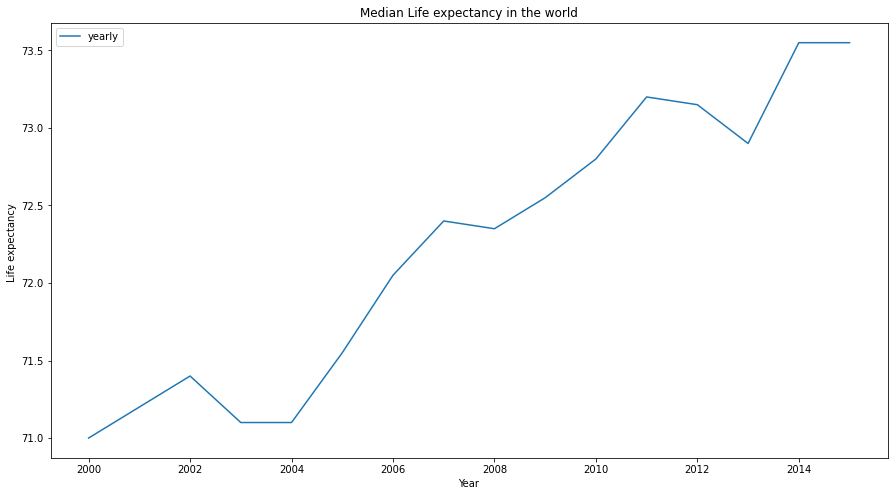

In [164]:
fig = plt.figure(figsize=(15, 8))
sns.lineplot(data=data.groupby('Year').median(), x='Year', y='Life expectancy ', label='yearly')
plt.title('Median Life expectancy in the world')

#### Distribution of Life Expectancy

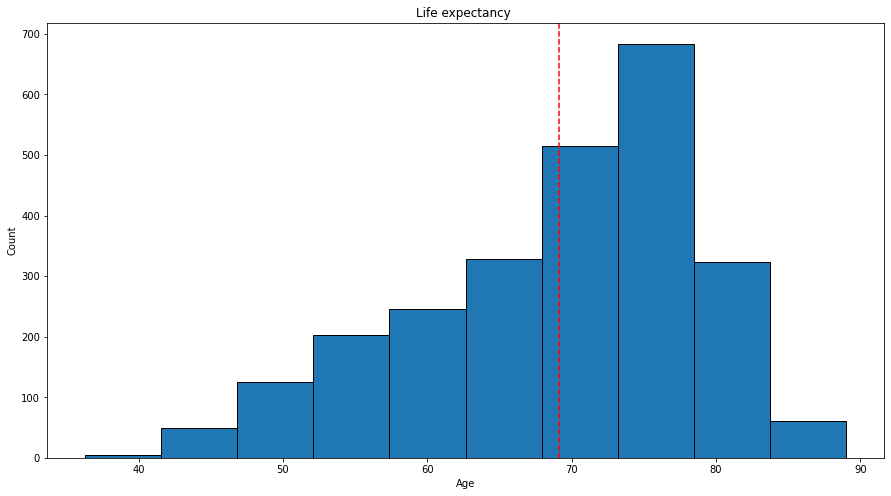

In [165]:
col = 'Life expectancy '

plt.figure(figsize=(15, 8))
plt.hist(data[col], ec='black')
plt.title(col)
plt.xlabel('Age')
plt.ylabel('Count')

mean = data[col].mean()
mean

plt.axvline(mean, color='r', linestyle='--')

The bar historgram displays that the majority of lifespan lies between 45 to 90 years with an average lifespan of 69 in the world.

__For better visualization, let's compare the life expectancy in different continents__

Outlier in North America life expectancy dataset:
Country: Haiti. Mean lifespan: 36.3 


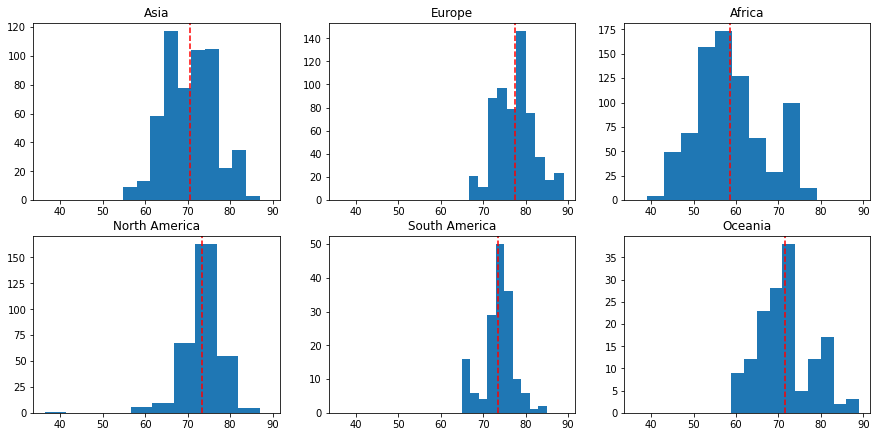

In [166]:
plt.figure(figsize=(15,15))

axes = []
for i, continent in enumerate(data['Continent'].unique(), 1):
    cont_countries = data[data.Continent == continent]   # all the countries from the continent, all years
    cont_lifespan = cont_countries[col]    # life span column
    
    if continent == 'North America':
        lowest_lifespan = min(cont_lifespan)
        country_with_lowest = pd.DataFrame(cont_countries.loc[cont_countries[col] == lowest_lifespan])
        mean_lifespan = cont_countries.loc[cont_countries[col] == lowest_lifespan][col].mean()
        print("Outlier in North America life expectancy dataset:")
        print(f"Country: {country_with_lowest.Country.item()}. Mean lifespan: {mean_lifespan} ")
        
    if (i == 1):
        ax = plt.subplot(4,3,i)
        axes.append(ax)
    else:
        plt.subplot(4,3,i, sharex = axes[0])
        
    plt.hist(cont_lifespan)
    plt.title(continent)
    
    plt.axvline(cont_lifespan.mean(), color='r', linestyle='--')

According to the plots, we can observe that lifespan in different continents various but some of them have a significant distinction. For example, average lifespan in Europe(77) and Africa(58). 

Does it mean that the countries in Europe are on the top of the list in average life expectancy?

Text(0, 0.5, 'Average lifespan')

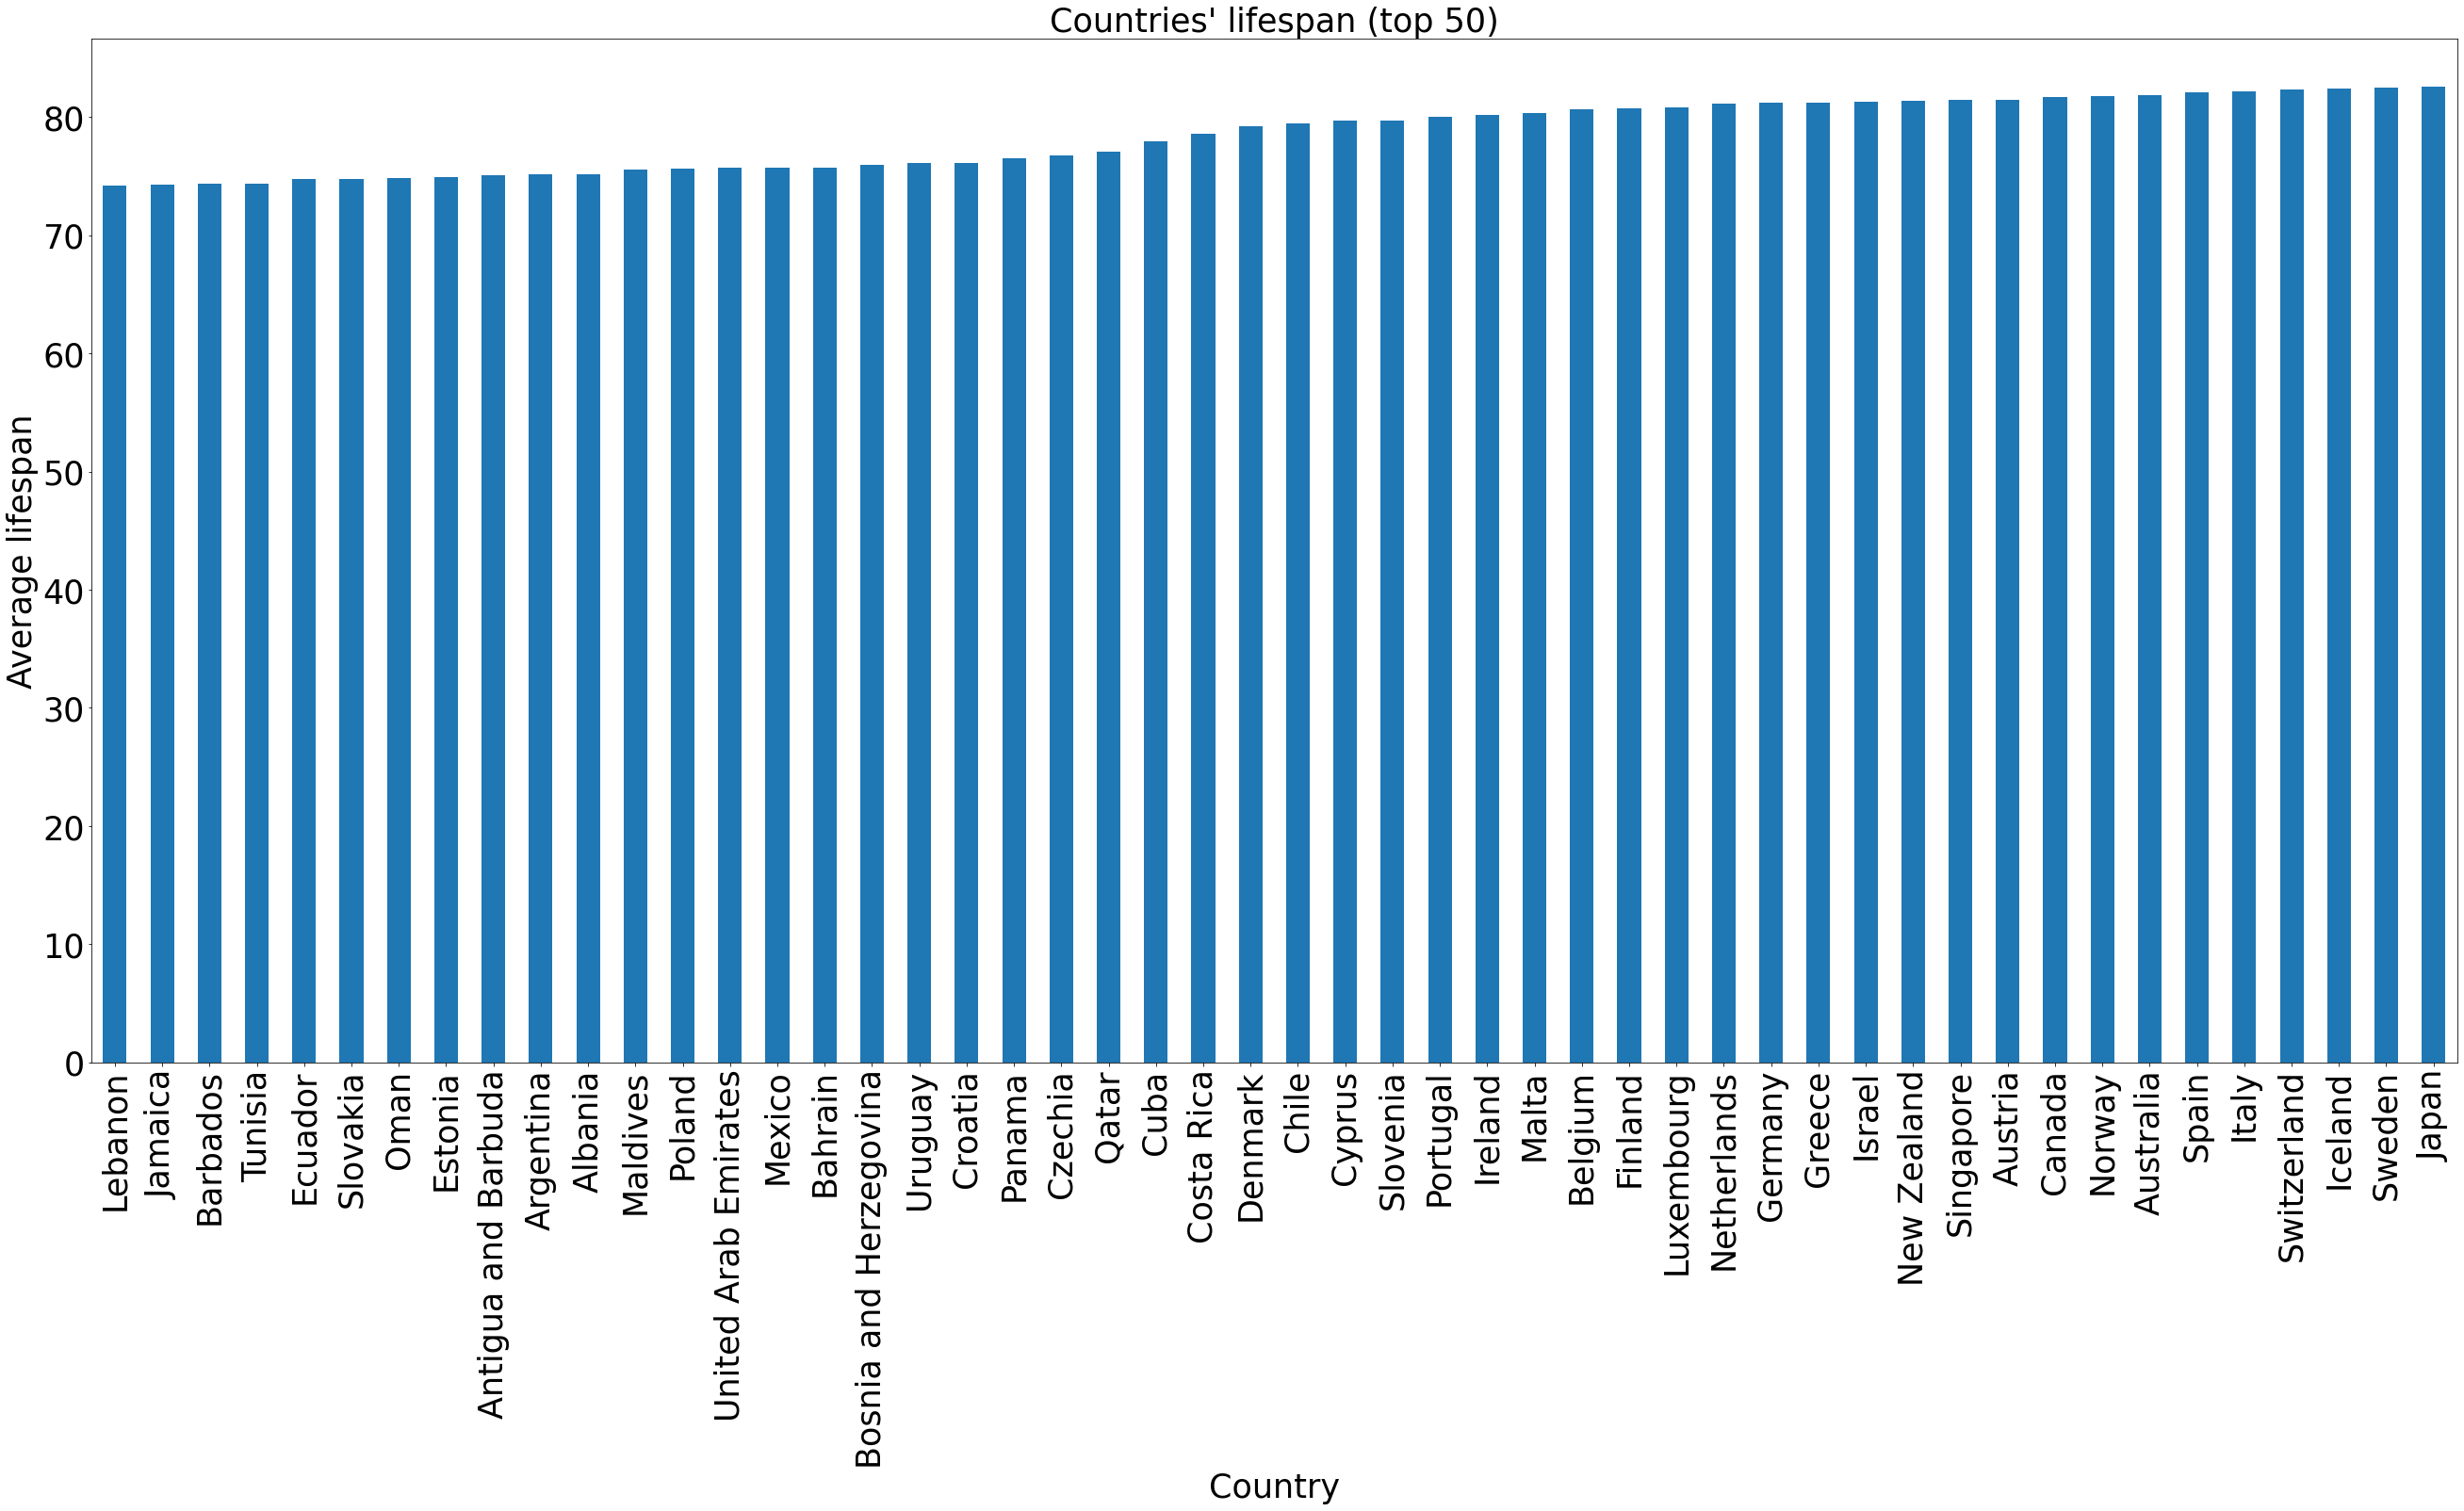

In [167]:
# get top 50 countries with hightest lifespan
countries_lifespan = data.groupby('Country')[col].mean()
sorted_countries_lifespan = countries_lifespan.sort_values(ascending=True)
top_countries_lifespan = sorted_countries_lifespan[-50:]

top_countries_lifespan.plot(kind='bar', figsize=(45,20), fontsize=35)
plt.title(f"Countries' lifespan (top 50)", fontsize=35)
plt.xlabel("Country", fontsize=35)
plt.ylabel("Average lifespan", fontsize=35)

We can observe that not all the countries in the top of the list are from Europe. Japan is the country with the highest life expectancy.

What? why? 

## What is the impact of schooling on the lifespan of humans in developed and developing countries?


**Before comparing the countries based on their status, let's examine if schooling factor indeed affect the lifespan and if it does how much?**

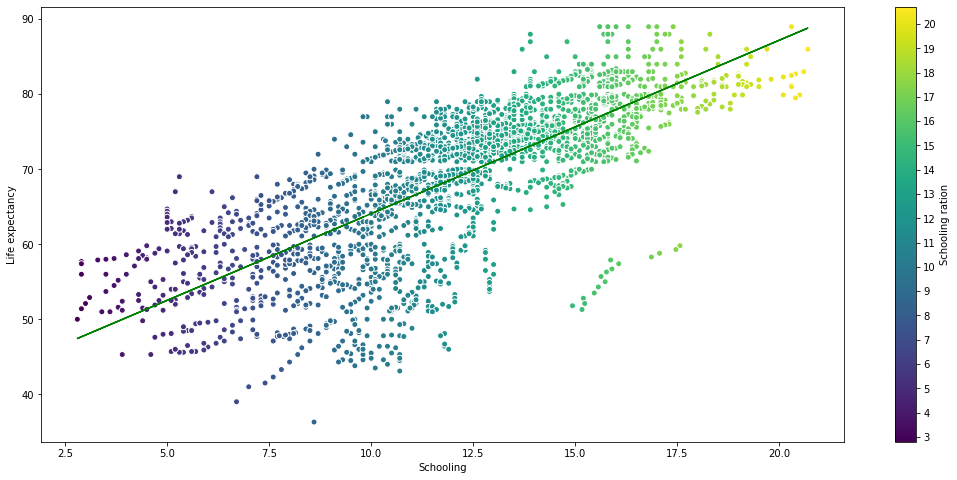

In [168]:
# display the data on the scatter plot
plt.figure(figsize=(18,8))
plt.scatter(data.Schooling, data[col], c=data.Schooling, edgecolors='white')
plt.xlabel('Schooling')
plt.ylabel('Life expectancy')
plt.rcParams['axes.grid'] = False
cbar=plt.colorbar(ticks=range(1, 22))
cbar.set_label('Schooling ration', rotation=90)

#display the regression line
m, b = np.polyfit(data.Schooling, data[col], 1)

plt.plot(data.Schooling, m*data.Schooling + b, c='g')

The figure above represents that schooling and life expectancy has a positive correlation: higher the average number of years of schooling a person receives the longer lifespan they expected to have.

Now, let's see how much impact schooling variable has in developing versus developed countries. Is it the same? 

Text(0.5, 0, 'Schooling')

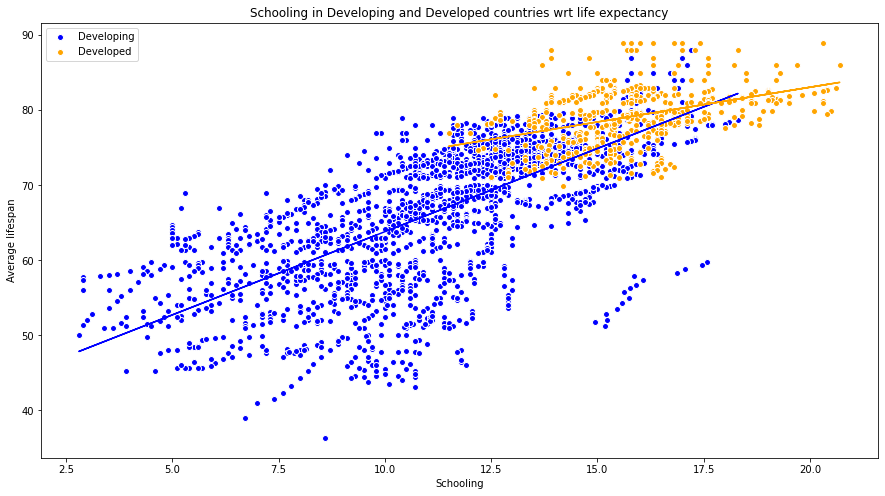

In [169]:

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot()

developing = data[data.Status == "Developing"]
developed  = data[data.Status == "Developed"]

#display scatter points of each status
ax.scatter(developing.Schooling, developing[col], c='blue', edgecolors='white', label='Developing')
ax.scatter(developed.Schooling, developed[col], c='orange', edgecolors='white', label='Developed')
plt.legend(loc='upper left')

#display regression line for each status
m1, b1 = np.polyfit(developing.Schooling, developing[col], 1)
m2, b2 = np.polyfit(developed.Schooling, developed[col], 1)

plt.plot(developing.Schooling, m1*developing.Schooling + b1, c='blue')
plt.plot(developed.Schooling, m2*developed.Schooling + b2, c='orange')

plt.title('Schooling in Developing and Developed countries wrt life expectancy')
plt.ylabel('Average lifespan')
plt.xlabel('Schooling')

We can observe that the blue slope is steeper than the orange one. This implies that schooling in developing countries has more impact on life expectancy than in developed countries. 

## What is the impact of economical factor on life Expectancy?

1. GDP
2. percentage_expenditure (Ratio) - expenditure on health as a percentage of Gross Domestic Product (gdp)
3. total_expenditure (Ratio) - government expenditure on health as a percentage of total government expenditure

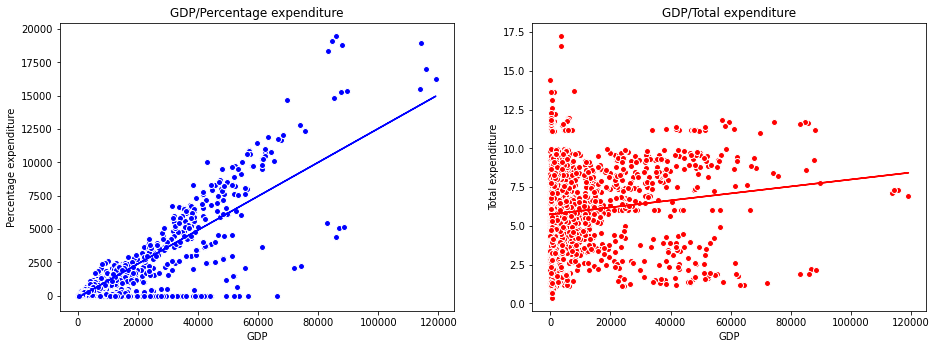

In [170]:
p_exp = 'percentage expenditure'
t_exp = 'Total expenditure'

plt.figure(figsize=(24,18))
plt.subplot(3,3,1)
plt.scatter(data.GDP, data[p_exp], c='blue', edgecolors='white')
plt.title('GDP/Percentage expenditure')
plt.ylabel('Percentage expenditure')
plt.xlabel('GDP')

m1, b1 = np.polyfit(data.GDP, data[p_exp], 1)
plt.plot(data.GDP, m1*data.GDP + b1, c='blue')

plt.subplot(3,3,2)
plt.scatter(data.GDP, data[t_exp], c='red', edgecolors='white')
plt.title('GDP/Total expenditure')
plt.ylabel('Total expenditure')
plt.xlabel('GDP')

m2, b2 = np.polyfit(data.GDP, data[t_exp], 1)
plt.plot(data.GDP, m2*data.GDP + b2, c='red')

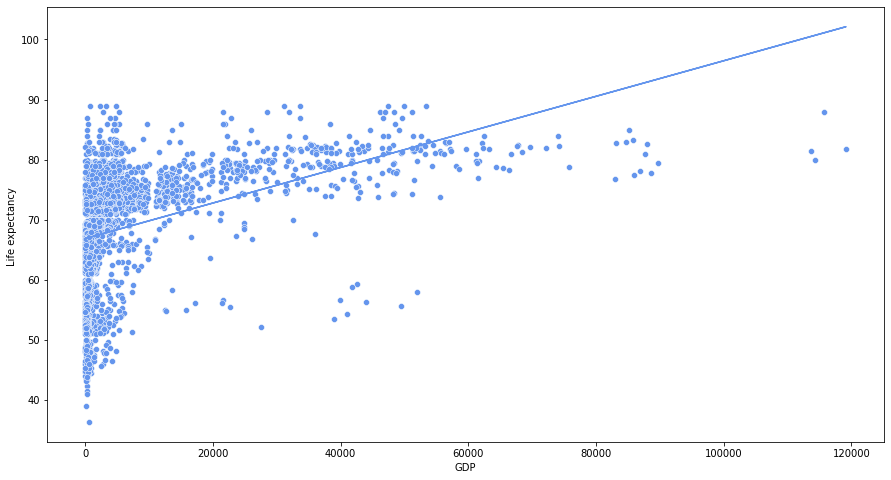

In [171]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=data.GDP, y=data[col], color='cornflowerblue')

m, b = np.polyfit(data.GDP, data[col], 1)
plt.plot(data.GDP, m*data.GDP + b, c='cornflowerblue')

The impact of economical factors on life expectancy is quite significant. We considered percentage and total expenditure, and GDP under economic factor. According to the graphs above, we can see that GDP has a influence on percentage and total expenditure. This implies that if a country has a high GDP then people residing in this country have a good health care system as expenditure on health depends on GDP. Therefore, we can say that GDP has positive correlation with Life expectancy according to the data. In the figure above, we can see the steep slope indicating that countries with high GDP have longer lifespan

## What is the life expectancy of male and female in developing and developed countries?

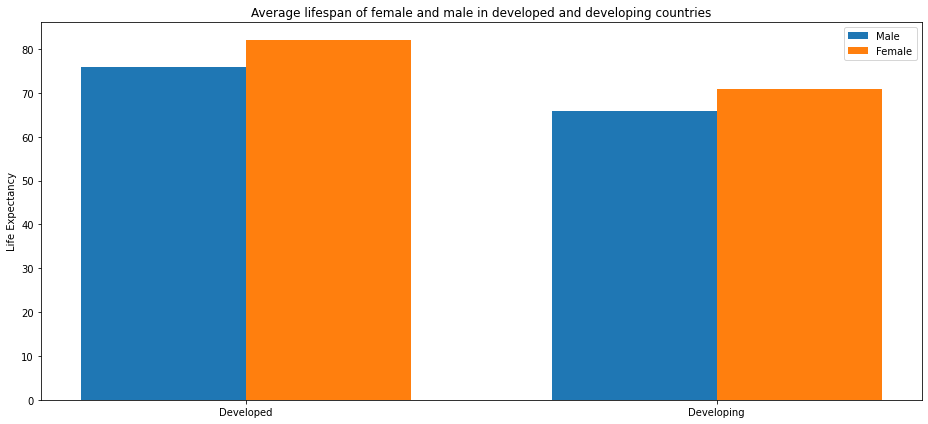

In [172]:
status = ['Developed', 'Developing']
male_mean = data.groupby(['Status'])['Male Life'].mean().values.astype(int)
female_mean = data.groupby(['Status'])['Female Life'].mean().values.astype(int)

x = np.arange(len(status))
width = 0.35

fig, ax = plt.subplots(figsize=(13,6))
rects1 = ax.bar(x - width/2, male_mean, width, label='Male')
rects2 = ax.bar(x + width/2, female_mean, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Life Expectancy')
ax.set_title('Average lifespan of female and male in developed and developing countries')
ax.set_xticks(x)
ax.set_xticklabels(status)
ax.legend()

fig.tight_layout()

plt.show()

From the data shown in the graph, we could conclude that the women live longer than men. Additionally, we could assume that no matter the status of the country(developed/developing), the lifespan of women is still longer than men.(but shorter than in developed countries)

## What is the impact of Immunization coverage on life Expectancy?

<AxesSubplot:>

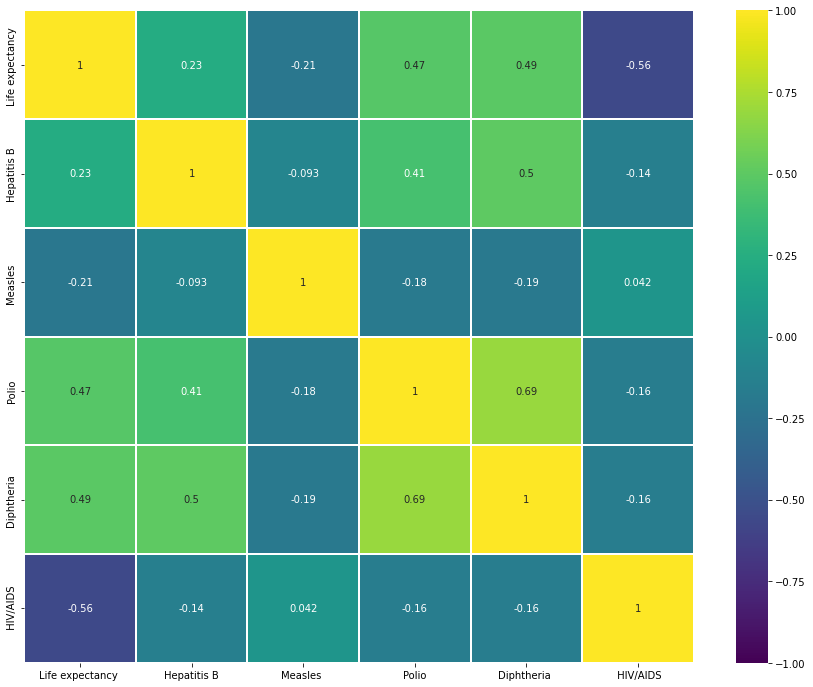

In [173]:
# get data of life expectancy with all immunization
sub_data = data[['Life expectancy ', 'Hepatitis B', 'Measles ', 'Polio', 'Diphtheria ', ' HIV/AIDS']]

plt.figure(figsize=(15,12))
sns.heatmap(sub_data.corr(), vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=0.1)

As we can observe from the above heatmap correlations, there is a positive correlation between -
- Life expectancy-Polio = 0.47
- Life expectancy-Diphtheria = 0.49
- Life expectancy-Hepatitis B = 0.23

and negative correlation between -
- Life expectancy-Measles = -0.21
- Life expectancy-HIV/AIDS = -0.56

The results could be a bit surprising as one might assume that all diseases cause death and vaccinated against them will prevent dying. 

In my opinion, this could be happening because we may have lost the critical values that creates inconsistent correlations.

## Anyone familiar with Kyrgyzstan?

In [174]:
data_kgz = data[data['Country'] == 'Kyrgyzstan']
data_world = data[data['Country'] != 'Kyrgyzstan']

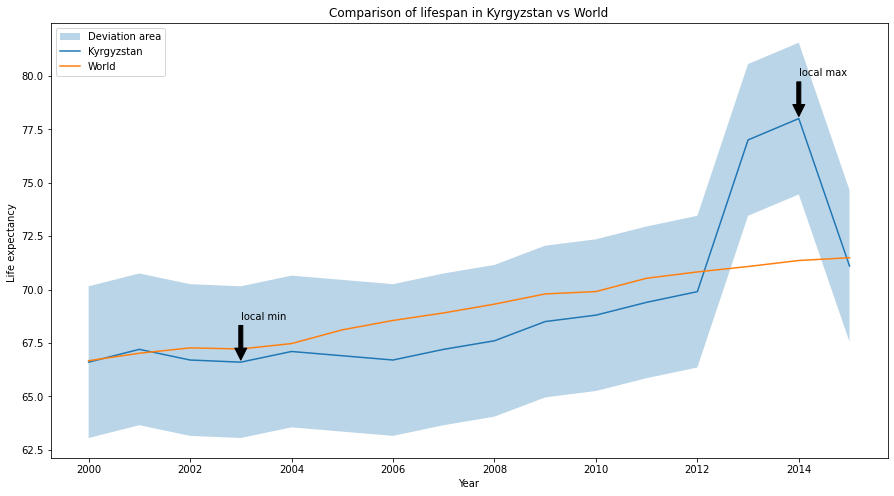

In [175]:
fig = plt.figure(figsize=(15, 8))

# max
ymax = max(data_kgz[col])
xpos = data_kgz[col].values.tolist().index(ymax)
xmax = data_kgz.Year.values.tolist()[xpos]

plt.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax+2), 
             arrowprops=dict(facecolor='black', shrink=0.05))

# min
ymin = min(data_kgz[col])
xpos = data_kgz[col].values.tolist().index(ymin)
xmin = data_kgz.Year.values.tolist()[xpos]

plt.annotate('local min', xy=(xmin, ymin), xytext=(xmin, ymin+2), 
             arrowprops=dict(facecolor='black', shrink=0.05))

# standard deviation part
std = data_kgz[col].std()

lower = []
upper = []

for lexp in data_kgz[col]:
    lower.append(lexp - std)
    upper.append(lexp + std)
    
plt.fill_between(data_kgz.Year, lower, upper, alpha=0.3, label="Deviation area")
plt.plot(data_kgz.Year, data_kgz[col], label='Kyrgyzstan')

# world
sns.lineplot(data=data_world.groupby('Year').mean(), x='Year', y='Life expectancy ', label='World')

plt.title('Comparison of lifespan in Kyrgyzstan vs World')
plt.legend(loc='upper left')

### Let's compare the expenditure on health in Kyrgyzstan vs World

Total expenditure: General government expenditure on health as a percentage of total government expenditure (%)

World: 5.915904403014677
Kyrgyzstan: 6.11125


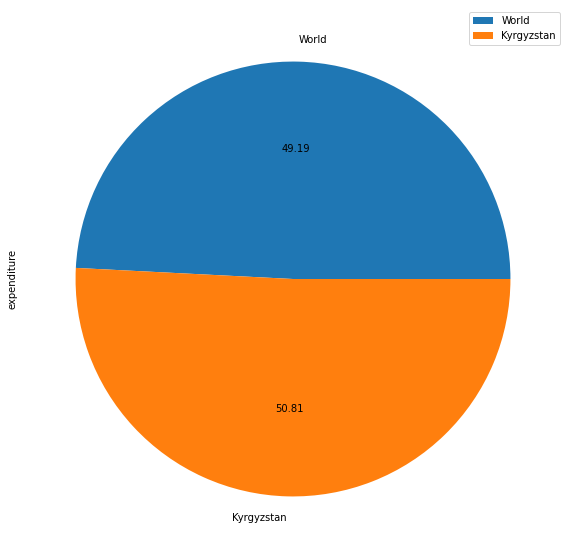

In [176]:
expenditure = []
expenditure.append(data_world['Total expenditure'].mean())
expenditure.append(data_kgz['Total expenditure'].mean())
df = pd.DataFrame({'expenditure': expenditure}, ['World', 'Kyrgyzstan'])
df.plot.pie(y='expenditure', figsize=(10,10), autopct='%.2f')
print(f"World: {expenditure[0]}")
print(f"Kyrgyzstan: {expenditure[1]}")      

## Linear Regression

We need to find a good relationship between two variables in this dataset. A good correlation will give us better, more accurate results. Therefore, the next steps would be to check the heatmap and find good relationships between the columns

<AxesSubplot:>

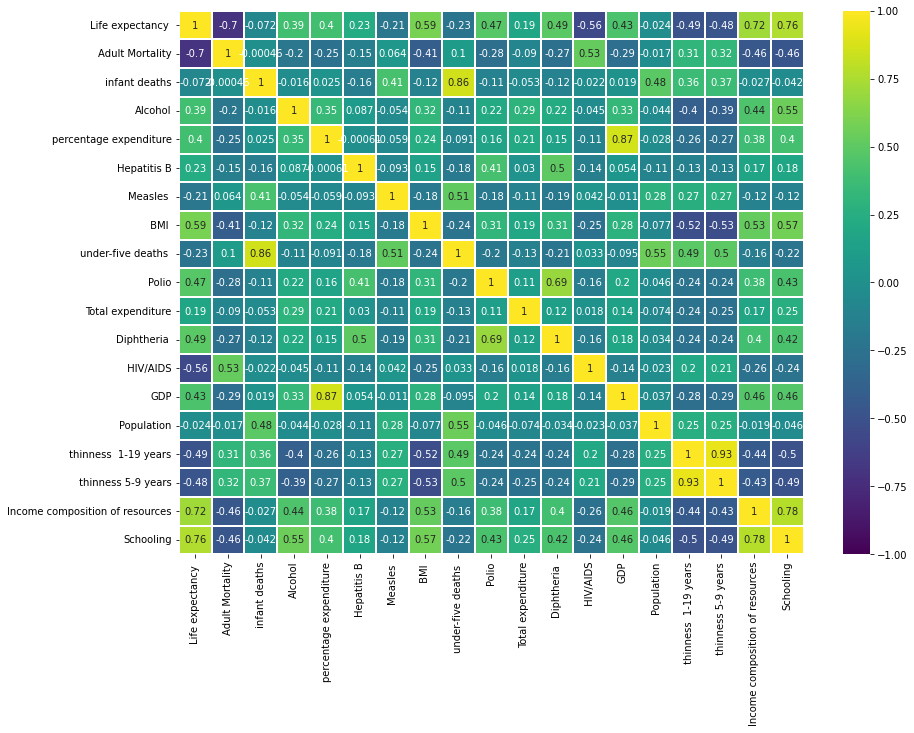

In [177]:
# get numeric data frame
data_factors = data.iloc[:, 3:-5]

# plot on the heat map the correlations 
plt.figure(figsize=(14,10))
sns.heatmap(data_factors.corr(),vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=0.1)


# Parial dependency display and apply it 

According to this heatmap, there is a positive relationship between 'GDP/percent expenditure', 'under five/infant deaths', thinnes 5-9 years/thinnes 1-19 years', 'Schooling/life expectancy' and etc.

In this case, I would like to consider Schooling and Life expectancy. Let's see what increase in schooling years are compared to Life expectancy.

In [178]:
# define features and targets
data_target = data_factors[col]   # target is life expectancy column
data_features = data_factors.drop(col, axis=1)    # everything else is features

In [179]:
# standardize the data
preprocessor = MinMaxScaler()
data_features_standardized = preprocessor.fit_transform(data_features)
data_features_standardized

array([[0.36288089, 0.03390773, 0.        , ..., 0.60350877, 0.50527426,
        0.40782123],
       [0.10110803, 0.02251251, 0.25699888, ..., 0.04210526, 0.80379747,
        0.63687151],
       [0.02493075, 0.01111729, 0.25927178, ..., 0.2       , 0.78375527,
        0.64804469],
       ...,
       [0.34764543, 0.02612563, 0.00335946, ..., 0.49122807, 0.45991561,
        0.27374302],
       [0.84903047, 0.02390217, 0.14613662, ..., 0.25964912, 0.44092827,
        0.37988827],
       [0.91966759, 0.01278488, 0.09350504, ..., 0.38947368, 0.45780591,
        0.39106145]])

In [180]:
# Split features and target into training and testing data
x_train, x_test, y_train, y_test = train_test_split(data_features_standardized, data_target, train_size=0.7, test_size=0.3)

In [181]:
# train the model
model = LinearRegression()
model.fit(x_train, y_train)

#prediction
prediction = model.predict(x_test)
print(f"R_square Score: {r2_score(y_test, prediction): .2f}")

R_square Score:  0.82


### One-way Partial Dependency Display on Adult mortality feature

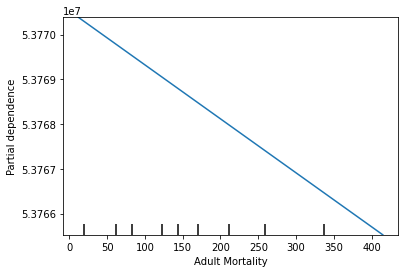

In [182]:
PartialDependenceDisplay.from_estimator(model, X=data_features, features=[0])

In the above plot, we displayed a grid of partial dependence plots: One-way PDP for feature 0 (Adult mortality)

## KMeans clustering based on Schooling and Alcohol

In [184]:
# define features and targets
data_target = data_factors[col]
data_features = data_factors.drop(col, axis=1)

preprocessor = StandardScaler()
variables = data_features.columns
data_features_stand = preprocessor.fit_transform(data_features)
data_features_stand = pd.DataFrame(data_features_stand, columns=data_features.columns)
data_clust = data_features_stand.copy()
data_clust.head(2)

,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0.765672,0.095892,-1.158773,-0.356084,-0.625026,-0.100616,-0.970071,0.232436,-3.218314,0.990882,-0.716152,-0.329782,-0.493229,0.38026,2.746763,2.709056,-0.729877,-0.646235
1,-0.726138,-0.051364,-0.002494,-0.215867,0.772584,-0.207435,0.985342,-0.256078,0.715703,0.036609,0.710035,-0.329782,-0.257226,-0.20324,-0.820535,-0.793224,0.618679,0.632066


In [185]:
n_clusters=6

# clustering
kmeans = KMeans(n_clusters=n_clusters).fit(data_clust)

# cluster centers
centers = kmeans.cluster_centers_

print(centers)

y_kmeans = kmeans.predict(data_clust)
y_kmeans

[[-8.11640906e-01  9.21203988e-02  1.05136077e+00  2.83433058e+00
  -7.66064803e-02 -1.37312628e-01  7.34374875e-01 -2.51265183e-01
   4.90027113e-01  6.36185291e-01  4.57734834e-01 -3.29782016e-01
   2.70278693e+00 -6.29579714e-02 -8.13395593e-01 -8.24602562e-01
   1.18632642e+00  1.27943335e+00]
 [ 2.36916263e+00 -1.53687793e-01 -1.73071344e-01 -3.04071624e-01
  -3.44287030e-01  1.10548919e-01 -6.75951902e-01 -9.62980593e-03
  -1.77573299e-01  2.99522641e-01 -1.31130042e-01  4.33484494e+00
  -4.20933657e-01 -7.73791296e-02  7.39209158e-01  7.90719131e-01
  -7.08433786e-01 -5.20528083e-01]
 [ 5.72549135e-01  1.16335192e-01 -3.95180791e-01 -3.26682120e-01
  -1.06412311e+00  3.08787850e-01 -6.35976420e-01  2.88504642e-01
  -1.70448532e+00 -3.19110624e-01 -1.77221536e+00  1.92970616e-01
  -3.59212941e-01 -3.76201131e-04  2.65026788e-01  2.48185573e-01
  -7.95486758e-01 -8.85691306e-01]
 [ 3.71710731e-01 -6.96590406e-02 -6.19159655e-01 -3.36601323e-01
   9.82353744e-02 -5.02603544e-02 -8.

array([2, 4, 4, ..., 3, 1, 1])

In [186]:
print(data_clust.columns[-1])
kmeans.cluster_centers_[:,-1]

Schooling


array([ 1.27943335, -0.52052808, -0.88569131, -0.79061594,  0.49639043,
       -0.7090865 ])

### My selected variable indexes to plot

In [187]:
schooling_idx = np.where(data_clust.columns == 'Schooling')[0][0]
alcohol_idx = np.where(data_clust.columns == 'Alcohol')[0][0]

### The simplest graph

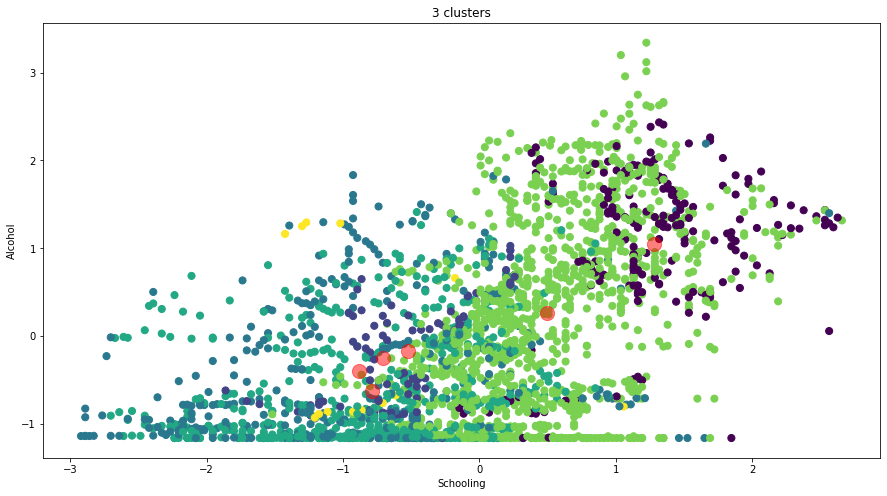

In [188]:
fig = plt.figure(figsize=(15, 8))
plt.scatter(data_clust.Schooling, data_clust.Alcohol, c=y_kmeans, s=50, cmap='viridis')
plt.xlabel('Schooling')
plt.ylabel('Alcohol')
plt.title(f"3 clusters")

plt.scatter(centers[:,schooling_idx], centers[:,alcohol_idx], c='red', s=200, alpha=0.5)

### Zoomed In

(-1.0, 1.5)

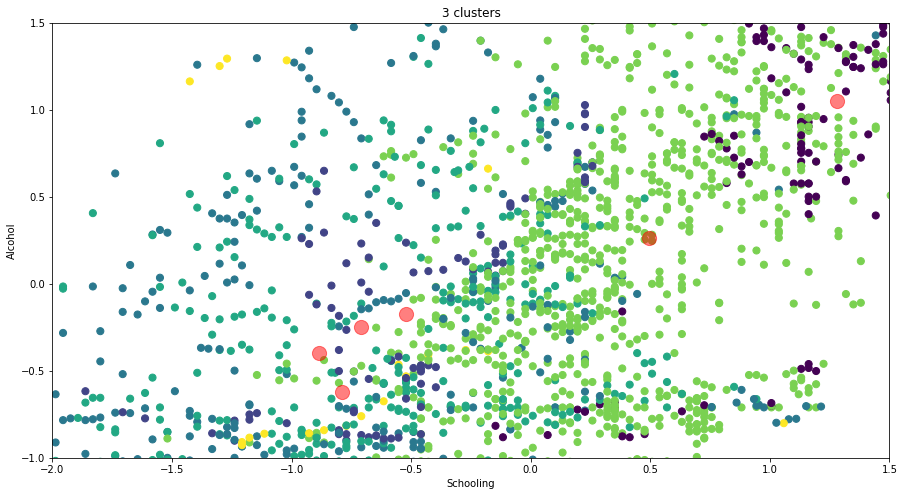

In [189]:
fig = plt.figure(figsize=(15, 8))
plt.scatter(data_clust.Schooling, data_clust.Alcohol, c=y_kmeans, s=50, cmap='viridis')
plt.xlabel('Schooling')
plt.ylabel('Alcohol')
plt.title(f"3 clusters")

plt.scatter(centers[:,schooling_idx], centers[:,alcohol_idx], c='red', s=200, alpha=0.5)

plt.xlim(-2,1.5)
plt.ylim(-1, 1.5)

### PCA on the Data
Find best 2 directions to plot

In [190]:
n_components=2

pca = PCA(n_components=n_components)
pca.fit(data_clust)

PCA(n_components=2)

In [191]:
print(pca.components_)
print('Explained variance: {}'.format(pca.explained_variance_))

[[ 0.23366985  0.14912088 -0.23757012 -0.21679217 -0.14074041  0.1481339
  -0.29211891  0.22420551 -0.2326557  -0.14135005 -0.23638615  0.14438137
  -0.23415374  0.11141618  0.32470825  0.32471805 -0.31424154 -0.33863024]
 [-0.18132159  0.49299668  0.13902333  0.22368198 -0.05130152  0.3140967
   0.06021738  0.46276198  0.04696244  0.01180595  0.04050683 -0.12991587
   0.2398768   0.38087818  0.13730742  0.14020098  0.19991732  0.18358331]]
Explained variance: [5.55191701 2.62462371]


#### Transform the cluster centres to PCA coordinates

In [192]:
X_pca = pca.transform(data_clust)
centers_pca = pca.transform(centers)

#### The graph in the new coordinates

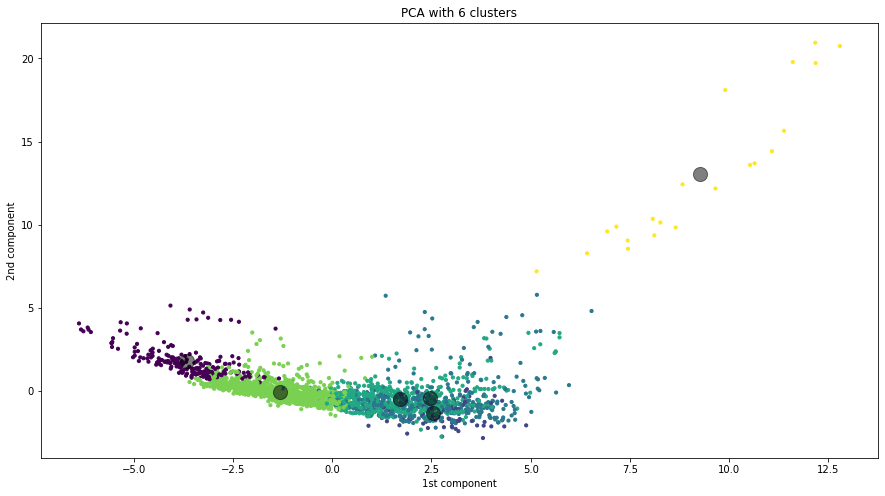

In [193]:
fig = plt.figure(figsize=(15, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=10, cmap='viridis')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title('PCA with {} clusters'.format(n_clusters))

plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, alpha=0.5)
plt.show()

### Ploting the clusters one by one

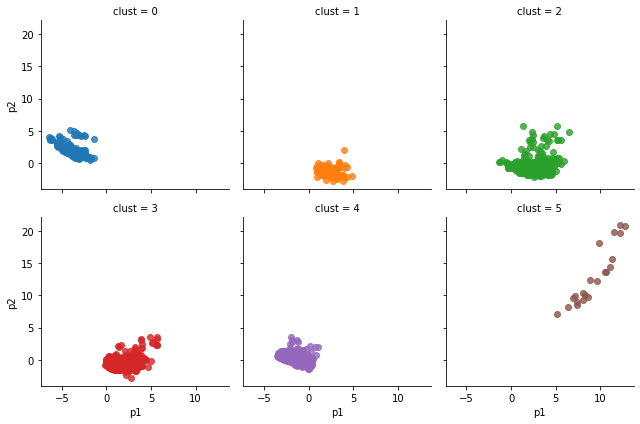

In [194]:
warnings.filterwarnings("ignore")

pca_df=pd.DataFrame({'p1':X_pca[:, 0], 'p2':X_pca[:, 1],'clust':y_kmeans})

sns.lmplot('p1','p2' ,data=pca_df, hue='clust',col='clust', fit_reg=False, col_wrap=3, height=3)